# Simulating DSA-200 Images

From tyrones_stuff, simulate a very large image, e.g.:

`python sky_model.py --first ~/catalogs/first/first_14dec17.fits -o test_first.fits`

or

`python sky_model.py --first /fastpool/claw/catalogs/first/first_14dec17.fits --agn /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_AGNs_complete_1sqdeg.fits --sfg /fastpool/claw/catalogs/trecs/1sq_deg_sfgs/catalogue_SFGs_complete_1sqdeg.fits -o /fastpool/claw/images/dsa2k_first+trecsagnsfg_4096.fits --npix 4096 --target 0 0 1 1`

Details at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf.

TODO: add more sources and make larger area. be sure to set npix to produce correct pixel scale

The simulation process will apply image-plane modifications as they are applied by propagation and measurement (going "forward").
1. apply ionospheric screen
2. apply primary beam and cut out 16k x 16k field (~10 sq deg)
3. add noise
4. convolve with PSF

Then iterate over new screens and pointing directions to create a sequence of measurements of a "tile" (e.g., 5x5).a

## Setup

In [1]:
import os.path
from scipy.interpolate import RBFInterpolator, CloughTocher2DInterpolator
from multiprocess import Pool
from typing import Literal, Tuple, Union
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.wcs as wcs
from astropy.io import fits

import numpy as np
from jax.scipy.signal import convolve
import jax.numpy as jnp
from jaxtyping import Array
import pandas as pd

In [2]:
from data import fits_image
from util import indices, rescale_quantile, gaussian_filter, match_histograms
from interactive import toggle_images, plot_image, sequence_images

In [3]:
def compute_offsets(dxmodel, dymodel):
    # compute each row separately
    def calc_row(r):
        # all indices with row r
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()  
        xy[:, 0] = r
        row_offsets = np.stack((dxmodel(xy), dymodel(xy)), axis=-1)
        return row_offsets
    
    # Naive multiprocessing (computing each row separately):
    # Note: while this should be extremely parallelizable , something (likely the GIL)
    # is preventing us from achieving optimal performance. This seems to take about 3
    # minutes with multiprocessing (64 cores) and 4.5 minutes without. Thus, Amdahl's
    # law tells us that only about 25% of this task is parallelizable (though it
    # should be closer to 100%).
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(calc_row, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
        return res

    results = go()
    return np.concatenate(results)

def compute_interpolation(interp):
    def g(r):
        xy =  np.indices((1, IMAGE_SIZE)).squeeze().transpose()
        xy[:, 0] = r
        return interp(xy)
    
    # naive multiprocessing, see above
    def go():
        res = None
        with Pool(processes=CPU_COUNT) as p:
            try:
                res = p.map(g, list(range(IMAGE_SIZE)))
            except:
                p.close()
                import traceback
                raise Exception("".join(traceback.format_exception(*sys.exc_info())))
                
        return res

    results = go()
    interp_img = np.stack(results, axis=0)
    return interp_img


In [4]:
def reference_sources_nvss(catalog, min_flux=270) -> Tuple[SkyCoord, Array]:
    nvss = pd.read_csv(catalog, sep=r"\s+")
    sorted_nvss = nvss.sort_values(by=["f"])

    # cut off refernce sources below a certain flux density
    sorted_nvss = sorted_nvss[sorted_nvss["f"] >= min_flux]

    # get coordinates of each reference source
    nvss_orig = sorted_nvss[["rah", "ram", "ras", "dd", "dm", "ds"]].to_numpy()

    # get flux of each reference source in Jy
    fluxes = sorted_nvss[["f"]].to_numpy().squeeze() / 1000

    # manually convert HMS:DMS into degrees
    nvss_ra = (
        15 * nvss_orig[:, 0]
        + (15 / 60) * nvss_orig[:, 1]
        + (15 / 3600) * nvss_orig[:, 2]
    )
    nvss_dec = (
        nvss_orig[:, 3] + (1 / 60) * nvss_orig[:, 4] + (1 / 3600) * nvss_orig[:, 5]
    )

    positions = np.stack((nvss_ra, nvss_dec), axis=-1)

    return SkyCoord(positions, unit=(u.deg, u.deg)), jnp.array(fluxes)

In [5]:
def gkern(l=5, sig=1.0):
    """\
    Creates gaussian kernel with side length `l` and a sigma of `sig`.
    Reaches a maximum of 1 at its center value
    """
    ax = jnp.linspace(-(l - 1) / 2.0, (l - 1) / 2.0, l)
    gauss = jnp.exp(-0.5 * jnp.square(ax) / jnp.square(sig))
    kernel = jnp.outer(gauss, gauss)
    return kernel / kernel.max()

In [6]:
def pbcut(img, center, size):
    """ Multiple by Gaussian primary beam at location center (in (x,y) pixel coords) and width size (pixels).
    center and size in units of pixels
    """
    pb_kernel = gkern(size, size/4)  # TODO figure out width
    return np.array(img[(center[1]-size//2):(center[1]+size//2), (center[0]-size//2):(center[0]+size//2)]*pb_kernel)

## 1. Apply primary beam and cut out

In [7]:
# Details on simulation at https://github.com/Radio-Camera-Initiative/tyrones_stuff/blob/main/SURF_2021_Final_Report_v3.pdf
#input_image = '/home/claw/code/tyrones_stuff/test_first_2048.fits'  # toy image at 1350 MHz and FIRST catalog
input_image = '/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192.fits'

In [8]:
image, imwcs = fits_image(input_image)
IMAGE_SIZE = image.shape[0]
pixelscale = 2*3600/IMAGE_SIZE  # arcsec/pixel
CPU_COUNT = 2
WORKING_DIR = '/fastpool/claw/images/'
print(f'Image size: {IMAGE_SIZE} and scale {pixelscale}"/pixel')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Image size: 8192 and scale 0.87890625"/pixel


In [9]:
width = 3600 # arcsec
fields = {
    input_image.replace('.fits', '_sub1.fits'): (int((width/pixelscale))//2, int((width/pixelscale))//2),
    input_image.replace('.fits', '_sub2.fits'): (int((2*width/pixelscale))//2, int((width/pixelscale))//2),
    input_image.replace('.fits', '_sub3.fits'): (int((3*width/pixelscale))//2, int((width/pixelscale))//2),
    input_image.replace('.fits', '_sub4.fits'): (int((width/pixelscale))//2, int((2*width/pixelscale))//2),
    input_image.replace('.fits', '_sub5.fits'): (int((2*width/pixelscale))//2, int((2*width/pixelscale))//2),
    input_image.replace('.fits', '_sub6.fits'): (int((3*width/pixelscale))//2, int((2*width/pixelscale))//2),
    input_image.replace('.fits', '_sub7.fits'): (int((width/pixelscale))//2, int((3*width/pixelscale))//2),
    input_image.replace('.fits', '_sub8.fits'): (int((2*width/pixelscale))//2, int((3*width/pixelscale))//2),
    input_image.replace('.fits', '_sub9.fits'): (int((3*width/pixelscale))//2, int((3*width/pixelscale))//2)
}

In [10]:
overwrite = False

wcss = fields.copy()


for name, center in fields.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
        print(f'not overwriting {name}')
        continue
    output_pbcut = pbcut(image, center, int(width/pixelscale))
#    output_image = np.expand_dims(np.expand_dims(output_pbcut, 0), 0)

    image, w0 = fits_image(input_image)
    crval = w0.pixel_to_world(center[0], center[1])
    w0.wcs.crval = [crval.ra.value, crval.dec.value]
    w0.wcs.crpix = [int(width/pixelscale)//2, int(width/pixelscale)//2]
    hdr = w0.to_header()     # TODO: modified wcs to cutout region
    wcss[name] = w0
    fits.writeto(f"{os.path.join(WORKING_DIR, name)}", output_pbcut, header=hdr, overwrite=overwrite)

not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub1.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub2.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub3.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub4.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub5.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub6.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub7.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub8.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub9.fits


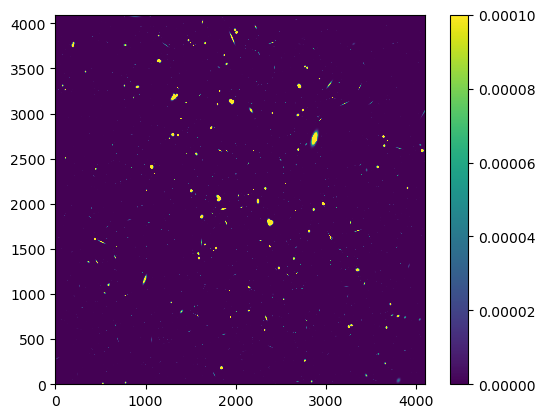

In [11]:
im = fits.open(f"{os.path.join(WORKING_DIR, list(fields.keys())[0])}")[0].data.squeeze()
plot_image(im, vmin=im.min(), vmax=0.0001)

## 2. Ionosphere (one per field)

## fake a warp screen with random ~PSF scale shifts at NVSS positions


In [184]:
catalog = '/fastpool/claw/catalogs/nvss_trim.dat'

In [19]:
overwrite = False

positions_xys = fields.copy()

for name, w in fields.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name)):
        print(f'not overwriting {name}')
        continue

    print(name)
    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    w = wcs.WCS(header=hdu.header)
    positions, fluxes = reference_sources_nvss(catalog=catalog)
    positions_xy = jnp.stack(wcs.utils.skycoord_to_pixel(positions, w), axis=1)
    fluxes = fluxes[~jnp.isnan(positions_xy).any(axis=1)]
    positions_xys[name] = positions_xy[~jnp.isnan(positions_xy).any(axis=1)]

not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub1.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub2.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub3.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub4.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub5.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub6.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub7.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub8.fits
not overwriting /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub9.fits


In [31]:
smoothing = 200
neighbors = 3
max_shift = 2
overwrite = False

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits'))):
        print('\tskipping', name)
        continue
    print(name)

    hdu = fits.open(f"{os.path.join(WORKING_DIR, name)}")[0]
    image = hdu.data
    hdr = hdu.header
    IMAGE_SIZE = image.shape[0]
    
    # create difference array
    diff = np.random.randint(-max_shift, max_shift+1, size=(len(positions_xy), 2))   
    dxmodel = RBFInterpolator(positions_xy, diff[:, 0], kernel='linear', smoothing=smoothing, neighbors=neighbors)
    dymodel = RBFInterpolator(positions_xy, diff[:, 1], kernel='linear', smoothing=smoothing, neighbors=neighbors)

    offsets = compute_offsets(dxmodel, dymodel)  # IMAGE_SIZE^2 x 2
    image_indices = np.indices((IMAGE_SIZE, IMAGE_SIZE)).swapaxes(0, 2)[:, :, ::-1].reshape((IMAGE_SIZE * IMAGE_SIZE, 2))
    interp = CloughTocher2DInterpolator(image_indices - offsets, np.ravel(image))  # very slow
    dewarped = compute_interpolation(interp)  # slow
    output_img = np.expand_dims(np.expand_dims(dewarped, 0), 0)  # if we're writing to FITS with same shape/header
    plot_image(output_img.squeeze(), vmax=1)
    plot_image((image-output_img.squeeze())[:2000,-2000:], vmin=-0.0001, vmax=0.0001)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warped.fits')), output_img, header=hdr, overwrite=overwrite)

	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub1.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub2.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub3.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub4.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub5.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub6.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub7.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub8.fits
	skipping /fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub9.fits


## 3. Add noise and convolve

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub1.fits
28.442507 16000 8192


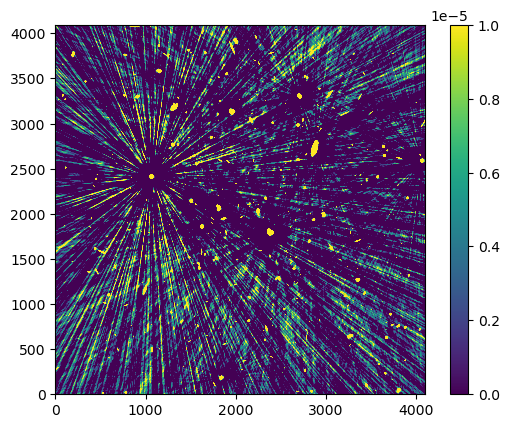

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub2.fits
28.442507 16000 8192


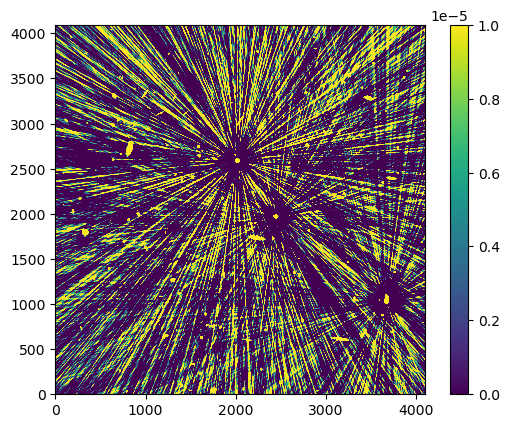

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub3.fits
28.442507 16000 8192


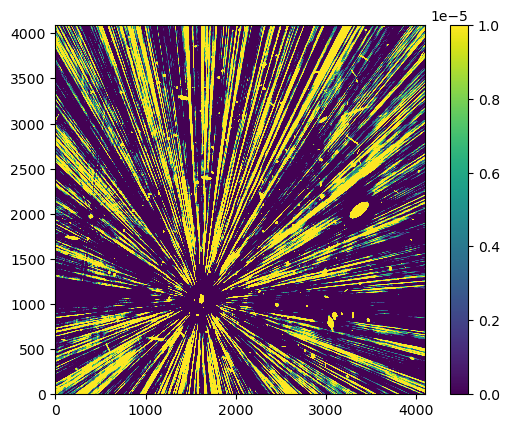

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub4.fits
28.442507 16000 8192


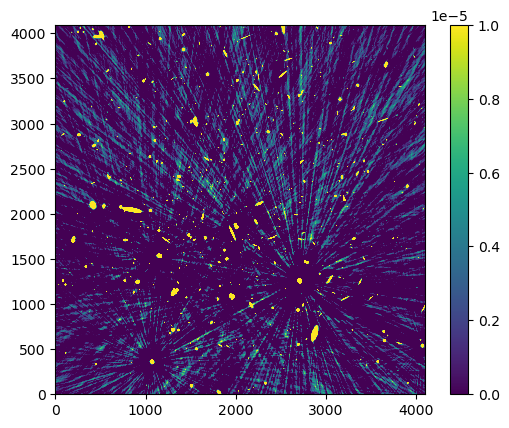

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub5.fits
28.442507 16000 8192


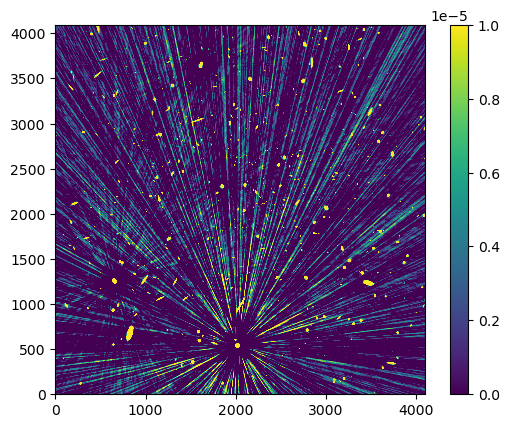

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub6.fits
28.442507 16000 8192


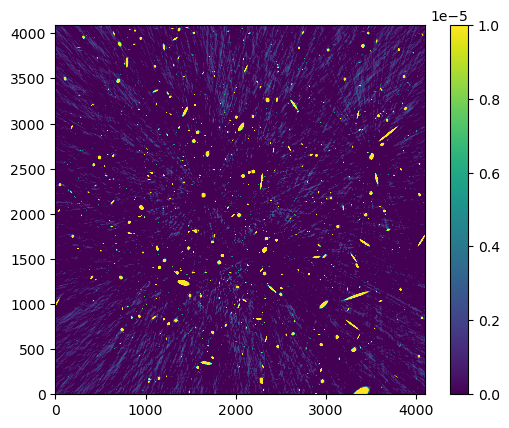

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub7.fits
28.442507 16000 8192


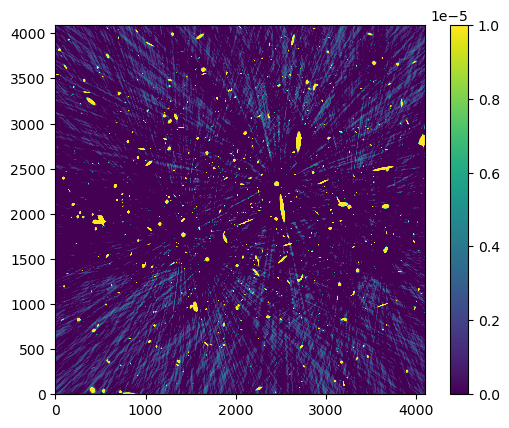

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub8.fits
28.442507 16000 8192


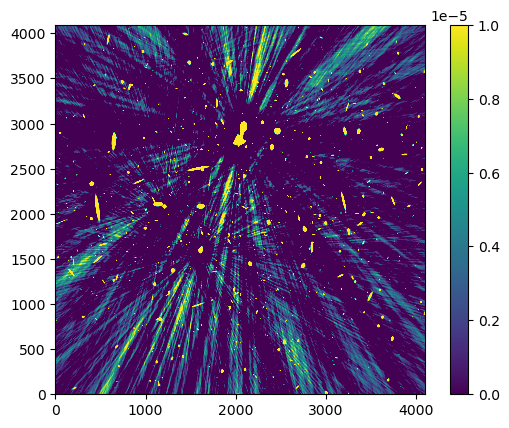

/fastpool/claw/images/dsa2k_first+trecsagnsfg_8192_sub9.fits
28.442507 16000 8192


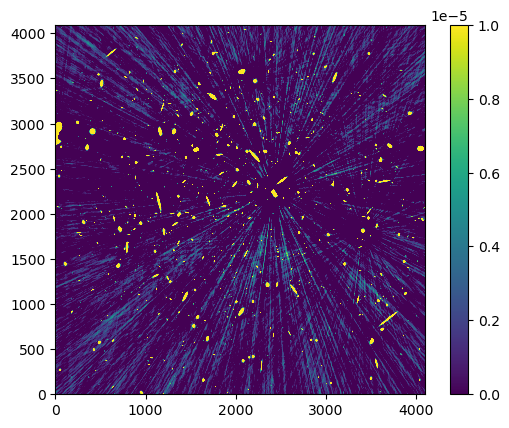

In [36]:
noise_sigma = 1e-6
realbeam = True
overwrite = True

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits'))):
        print('\tskipping', name)
        continue
    print(name)

    if realbeam:
        psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
        psf_image, psf_wcs = fits_image(psf_filename)

        # normalization factor for core of PSF that overlaps input image
        psf_width = psf_image.squeeze().shape[0]
        psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
                                       psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

        print(psf_norm, psf_width, IMAGE_SIZE)
    else:
        # overload with restoring beam
        psf_image = gkern(l=64, sig=3.3/pixelscale)
        psf_norm = psf_image.sum()

    hdu = fits.open(name.replace('.fits', 'warped.fits'))[0]
    image = np.ma.masked_invalid(hdu.data.squeeze())
    image.set_fill_value(0)
    hdr = hdu.header
    noise = np.random.normal(0, noise_sigma, size=image.shape)  # zero mean
    image_noise = image.filled()+noise
    noise_convolved = convolve(image_noise, psf_image/psf_norm, mode="same", method="fft")

    noise_convolved = np.array(noise_convolved)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits')), noise_convolved, header=hdr, overwrite=overwrite)
    plot_image(noise_convolved, vmax=1e-5)

In [18]:
# note that noise is double convolved

realbeam = True
overwrite = False

for name, positions_xy in positions_xys.items():
    if not overwrite and os.path.exists(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits'))):
        print('\tskipping', name)
        continue
    print(name)

    if realbeam:
        psf_filename = '/fastpool/data/W-GC-8000chan-briggs09-psf.fits'
        psf_image, psf_wcs = fits_image(psf_filename)

        # normalization factor for core of PSF that overlaps input image
        psf_width = psf_image.squeeze().shape[0]
        psf_norm = psf_image.squeeze()[psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2,
                                       psf_width//2-IMAGE_SIZE//2:psf_width//2+IMAGE_SIZE//2].sum()

        print(psf_norm, psf_width, IMAGE_SIZE)
    else:
        # overload with restoring beam
        psf_image = gkern(l=64, sig=3.3/pixelscale)
        psf_norm = psf_image.sum()

    hdu = fits.open(name.replace('.fits', 'warpednoiseconv.fits'))[0]
    image = np.ma.masked_invalid(hdu.data.squeeze())
    image.set_fill_value(0)
    hdr = hdu.header
    convolved = convolve(image, psf_image/psf_norm, mode="same", method="fft")

    convolved = np.array(convolved)
    fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'warpednoiseconv.fits')), cno, header=hdr, overwrite=overwrite)
    plot_image(image_noise, vmax=1e-6)
    image_convolved = convolve(image_noise, psf_image, mode="same", method="fft")

In [21]:
name = list(fields.keys())[0]
fits.writeto(os.path.join(WORKING_DIR, name.replace('.fits', 'noiseconv.fits')), image_convolved, header=hdr, overwrite=True)

## 5. (optional) Rescale if it must be normalized to 0-1 range

In [ ]:
# img1r = rescale_quantile(img1, 0.5, 0.95)